In [84]:
import numpy as np
import plotly.express as px
from tools.utils import query_database
import pandas as pd
import psycopg2
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import os
from scipy.io import wavfile

**Graphs**

- best models
- best accuracy
- best preprocesing
- loss
- accuracy


# Utils


In [85]:
from typing import Optional

SAVE_PATH = "../graphs"
SCALE = 1
HEIGHT = 900 * SCALE
WIDTH = 1200 * SCALE
FONT_SIZE = 14
narrow_scope = "and m.preprocessing != 'combined1' and m.preprocessing != 'combined2' and m.preprocessing != 'combined3' and m.preprocessing != 'combined4' and m.inclusion = 2000 and m.exclusion = 4000 and"


def get_cnn(
    optimiser: str,
    columns: str = "*",
    shot: Optional[int] = None,
    shuffle: Optional[int] = None,
    preprocessing: Optional[str] = None,
    order: Optional[str] = None,
    group: Optional[str] = None,
    limit: Optional[int] = None,
    where="",
    type="Accuracy",
) -> str:
    shuffle_condition = (
        f"and d.shuffle = '{shuffle}'"
        if shuffle is not None and shuffle != "null"
        else ("and d.shuffle is null" if shuffle == "null" else "")
    )
    shot_condition = (
        f"and d.shot = '{shot}'"
        if shot is not None and shot != "null"
        else ("and d.shot is null" if shot == "null" else "")
    )

    limit_clause = f"limit {limit}" if limit is not None else ""
    preprocessing_condition = (
        f"and m.preprocessing = '{preprocessing}'" if preprocessing is not None else ""
    )
    order_clause = f"order by\n\t{order}" if order is not None else ""
    group_clause = f"group by\n\t{group}" if group is not None else ""

    query = f"""
    select
        {columns}
    from
        model m
        join cnn_data d on m.id = d.model_id
        join epoch e on m.id = e.model_id
        join cnn_result r on e.id = r.epoch_id
    where 
        1 = 1
        {narrow_scope}
        m.type = 'cnn' {shot_condition} {shuffle_condition} {preprocessing_condition} and r.type = '{type}' and d.optimiser = '{optimiser}'
        {where}
    {group_clause}
    {order_clause}
    {limit_clause}
    """

    return query


def get_maml(
    columns: str = "*",
    shot: Optional[int] = None,
    preprocessing: Optional[str] = None,
    order: Optional[str] = None,
    group: Optional[str] = None,
    limit: Optional[int] = None,
    where="",
) -> str:
    shot_condition = (
        f"and d.k_spt = '{shot}'"
        if shot is not None and shot != "null"
        else ("and d.k_spt is null" if shot == "null" else "")
    )
    limit_clause = f"limit {limit}" if limit is not None else ""
    preprocessing_condition = (
        f"and m.preprocessing = '{preprocessing}'" if preprocessing is not None else ""
    )
    order_clause = f"order by\n\t{order}" if order is not None else ""
    group_clause = f"group by\n\t{group}" if group is not None else ""

    query = f"""
    select
        {columns}
    from
        model m
        join maml_data d on m.id = d.model_id
        join epoch e on m.id = e.model_id
        join maml_step ms on e.id = ms.epoch_id
        join maml_update_acc r on ms.id = r.maml_step_id
    where 
        1 = 1
        {narrow_scope}
        ms.type = 'evaluation' and m.type = 'maml' {shot_condition} {preprocessing_condition}
        {where}
    {group_clause}
    {order_clause}
    {limit_clause}
    """

    return query


def save_fig(fig, name, extension=".png"):
    path = os.path.join(SAVE_PATH, name + extension)

    fig.write_image(path)


def table_to_latex(df_list, file_name):
    with open(file_name, "w") as file:
        pass

    for df in df_list:
        temp_df = df[1].drop("id", axis=1)
        temp_df.columns = temp_df.columns.str.capitalize()
        table = temp_df.to_latex(index=False, float_format="{:.2f}".format)

        with open(file_name, "a") as file:
            file.write(f"{df[0]}\n")
            file.write(table)
            file.write("\n\n")

# Everything


## Top Performing


In [86]:
columns = "m.name, m.preprocessing, d.shot, d.shuffle, d.optimiser, e.epoch, r.value"
optimiser = "adam"
limit = 1
order = "r.value desc"

noShot = get_cnn(optimiser, columns, limit=limit, order=order)
fiveShot = get_cnn(optimiser, columns, limit=limit, shot=5, order=order)
tenShot = get_cnn(optimiser, columns, limit=limit, shot=10, order=order)
onefiveShot = get_cnn(optimiser, columns, limit=limit, shot=15, order=order)

query = f"""
with noShot as (
    {noShot}
),
fiveShot as (
    {fiveShot}
),
tenShot as (
    {tenShot}
),
fifthteenShot as (
    {onefiveShot}
),
combined as (
select * from noShot
union
select * from fiveShot
union
select * from tenShot
union
select * from fifthteenShot
)
select
    concat_ws(', ', shot, name, preprocessing, shuffle) as x_value, value as y_value
from combined
"""

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["y_value"] = df["y_value"].astype(float)
df["x_value"] = df["x_value"].astype(str)
df

,x_value,y_value
0,"5, resnet18_transfer, cqt, t",0.589558
1,"resnet18, stft",0.975586
2,"15, resnet18_transfer, cqt, t",0.670566
3,"10, resnet18, cqt, f",0.613323


In [87]:
x = df["x_value"]
y = df["y_value"]

fig = px.bar(df, x="x_value", y="y_value", text_auto=True, width=WIDTH, height=HEIGHT)
fig.update_layout(
    title="Top Performing Models of Each Shot (CNN)",
    xaxis_title="Model - (Shot, Name, Preprocessing, Shuffle)",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.show()
save_fig(fig, "Top Performing Models of Each Shot (CNN)")

In [88]:
limit = 1

cnn_columns = "concat_ws(', ', m.name, m.preprocessing, d.optimiser, d.shuffle, e.epoch) as x_value, r.value as y_value"
noShot = get_cnn(optimiser, cnn_columns, limit=limit, order="r.value desc")

order = "r.accuracy desc"
columns = "m.name, m.preprocessing, d.k_spt as shot, e.epoch, ms.step, r.update, r.accuracy as accuracy"

fiveShot = get_maml(columns, 5, limit=limit, order=order)
tenShot = get_maml(columns, 10, limit=limit, order=order)
onefiveShot = get_maml(columns, 15, limit=limit, order=order)

query = f"""
with fiveShot as (
    {fiveShot}
),
tenShot as (
    {tenShot}
),
fifthteenShot as (
    {onefiveShot}
),
combined as (
select * from fiveShot
union
select * from tenShot
union
select * from fifthteenShot
)
select
    concat_ws(', ', name, preprocessing, shot) as x_value, accuracy as y_value
from combined
"""

print(query)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["y_value"] = df["y_value"].astype(float)
df["x_value"] = df["x_value"].astype(str)


columns, rows = query_database(noShot)
df_cnn = pd.DataFrame(rows, columns=columns)
df_cnn["y_value"] = df_cnn["y_value"].astype(float)
df_cnn["x_value"] = df_cnn["x_value"].astype(str)
df_cnn

df = pd.concat([df, df_cnn])
df


with fiveShot as (
    
    select
        m.name, m.preprocessing, d.k_spt as shot, e.epoch, ms.step, r.update, r.accuracy as accuracy
    from
        model m
        join maml_data d on m.id = d.model_id
        join epoch e on m.id = e.model_id
        join maml_step ms on e.id = ms.epoch_id
        join maml_update_acc r on ms.id = r.maml_step_id
    where 
        1 = 1
        and m.preprocessing != 'combined1' and m.preprocessing != 'combined2' and m.preprocessing != 'combined3' and m.preprocessing != 'combined4' and m.inclusion = 2000 and m.exclusion = 4000 and
        ms.type = 'evaluation' and m.type = 'maml' and d.k_spt = '5' 
        
    
    order by
	r.accuracy desc
    limit 1
    
),
tenShot as (
    
    select
        m.name, m.preprocessing, d.k_spt as shot, e.epoch, ms.step, r.update, r.accuracy as accuracy
    from
        model m
        join maml_data d on m.id = d.model_id
        join epoch e on m.id = e.model_id
        join maml_step ms on e.id = ms.epoch_

,x_value,y_value
0,"original, cqt, 15",0.946667
1,"vggnet, cqt, 5",0.933333
2,"original, cqt, 10",0.973333
0,"resnet18, stft, adam, 34",0.975586


In [89]:
x = df["x_value"]
y = df["y_value"]

fig = px.bar(df, x="x_value", y="y_value", text_auto=True, width=WIDTH, height=HEIGHT)
fig.update_layout(
    title="Top Performing Models of Each Shot (MaML)",
    xaxis_title="Model - (Shot, Name, Preprocessing)",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.show()
save_fig(fig, "Top Performing Models of Each Shot (MaML)")

# Heatmap


In [90]:
def create_heatmap(x, y, z, title):
    annotations = []
    for i in range(len(z)):
        for j in range(len(z[i])):
            annotations.append(
                dict(
                    text=str(z[i][j]),
                    x=j,
                    y=i,
                    font=dict(color="white" if z[i][j] > np.max(z) / 2 else "black"),
                    showarrow=False,
                )
            )

    heatmap = go.Heatmap(z=z, colorscale="YlGnBu")

    # Define layout
    layout = go.Layout(
        title=title,
        annotations=annotations,
        xaxis=dict(ticks="", side="bottom", tickvals=np.arange(len(z[0])), ticktext=x),
        yaxis=dict(ticks="", ticksuffix=" ", tickvals=np.arange(len(z)), ticktext=y),
    )

    # Create figureh
    fig = go.Figure(data=[heatmap], layout=layout)
    fig.update_layout(
        height=HEIGHT,
        width=WIDTH,
        xaxis_title="Accuracy",
        yaxis_title="Shot",
        font=dict(size=FONT_SIZE),
    )

    return fig

In [91]:
query = """
with cnn_top as (
select
    max(cr.value) as max, cd.shot as shot, cd.shuffle as shuffle
from
    model m
    join epoch e on m.id = e.model_id
    join cnn_result cr on e.id = cr.epoch_id
    join cnn_data cd on m.id = cd.model_id
where
    cr.type = 'Accuracy' and cd.shot is not null
group by
    m.id, cd.shot, cd.shuffle
),
maml_top as (
select
    max(mr.accuracy) as max, md.k_spt as shot
from
    model m
    join epoch e on m.id = e.model_id
    join maml_step ms on e.id = ms.epoch_id
    join maml_update_acc mr on ms.id = mr.maml_step_id
    join maml_data md on m.id = md.model_id
group by
    m.id, md.k_spt
)
select
    max, shot, shuffle
from
    cnn_top
union
select
    max, shot, null as shuffle
from
    maml_top
"""


columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)

df["index"] = df.index
df["max"] = df["max"].astype(float)
df["shot"] = df["shot"].astype(int)

df

,max,shot,shuffle,index
0,0.350684,5,True,0
1,0.262372,10,False,1
2,0.504517,15,False,2
3,0.347334,15,True,3
4,0.370301,10,False,4
...,...,...,...,...
522,0.414049,5,False,522
523,0.469164,10,True,523
524,0.558198,15,False,524
525,0.587283,15,False,525


In [92]:
shot = [5, 10, 15]
shot_counts = {s: {} for s in shot}
entries = [round(i * 0.1, 2) for i in range(11)]

no_shuffle = [[0 for _ in range(10)] for _ in range(3)]
shuffle = [[0 for _ in range(10)] for _ in range(3)]
maml = [[0 for _ in range(10)] for _ in range(3)]

# Initialize a dictionary to hold counts for each interval
interval_counts = {}

# Define the interval width
interval_width = 0.10

# Iterate over the values and count them in intervals
for index, row in df.iterrows():
    interval = (
        int(row["max"] / interval_width) * interval_width
    )  # Determine the interval

    interval = round(interval, 2)
    entries_idx = entries.index(interval)

    if row["shot"] == 5 and row["shuffle"] == False:
        no_shuffle[0][entries_idx] += 1

    elif row["shot"] == 10 and row["shuffle"] == False:
        no_shuffle[1][entries_idx] += 1

    elif row["shot"] == 15 and row["shuffle"] == False:
        no_shuffle[2][entries_idx] += 1

    elif row["shot"] == 5 and row["shuffle"]:
        shuffle[0][entries_idx] += 1

    elif row["shot"] == 10 and row["shuffle"]:
        shuffle[1][entries_idx] += 1

    elif row["shot"] == 15 and row["shuffle"]:
        shuffle[2][entries_idx] += 1

    elif row["shot"] == 5 and row["shuffle"] is None:
        maml[0][entries_idx] += 1

    elif row["shot"] == 10 and row["shuffle"] is None:
        maml[1][entries_idx] += 1

    elif row["shot"] == 15 and row["shuffle"] is None:
        maml[2][entries_idx] += 1

## No Shuffle


In [93]:
fig = create_heatmap(entries, shot, no_shuffle, "No Shuffle Accuracy")

fig.show()
save_fig(fig, "Heatmap No Shuffle Accuracy")

## Shuffle


In [94]:
fig = create_heatmap(entries, shot, shuffle, "Shuffle Accuracy")

fig.show()
save_fig(fig, "Heatmap Shuffle Accuracy")

## MaML


In [95]:
fig = create_heatmap(entries, shot, maml, "MaML Accuracy")

fig.show()
save_fig(fig, "Heatmap MaML Accuracy")

# Preprocessing


## CNN


In [96]:
preprocessing = [
    ["stft", pd.DataFrame()],
    ["mel", pd.DataFrame()],
    ["gammatone", pd.DataFrame()],
    ["cqt", pd.DataFrame()],
]

query_columns = "m.id, m.name, d.shuffle, d.shot, max(r.value) as accuracy"
optimiser = "adam"
group = "m.id, m.name, d.shuffle, d.shot"

for p in preprocessing:
    query = get_cnn(
        optimiser=optimiser,
        preprocessing=p[0],
        columns=query_columns,
        shot="null",
        shuffle="null",
        group=group,
        order="accuracy desc",
        limit=3,
    )

    columns, rows = query_database(query)
    df = pd.DataFrame(rows, columns=columns)
    p[1] = pd.concat([p[1], df])

for p in preprocessing:
    print(p[0])
    p[1]["accuracy"] = p[1]["accuracy"].astype(float)
    print(p[1])
    print()

table_to_latex(preprocessing, "baseline_tables.txt")

stft
    id               name shuffle  shot  accuracy
0  914           resnet18    None  None  0.975586
1  916  resnet18_transfer    None  None  0.969032
2  917  vggnet16_transfer    None  None  0.564206

mel
    id               name shuffle  shot  accuracy
0  902           resnet18    None  None  0.539334
1  905  vggnet16_transfer    None  None  0.484413
2  903           vggnet16    None  None  0.418066

gammatone
    id               name shuffle  shot  accuracy
0  912  resnet18_transfer    None  None  0.869168
1  910           resnet18    None  None  0.868573
2  913  vggnet16_transfer    None  None  0.282468

cqt
    id               name shuffle  shot  accuracy
0  906           resnet18    None  None  0.909803
1  908  resnet18_transfer    None  None  0.851221
2  907           vggnet16    None  None  0.727755



/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which 

In [97]:
shot = [5, 10, 15]
preprocessing = [
    ["stft", pd.DataFrame()],
    ["mel", pd.DataFrame()],
    ["gammatone", pd.DataFrame()],
    ["cqt", pd.DataFrame()],
]

query_columns = "m.id, m.name, d.shuffle, d.shot, max(r.value) as accuracy"
optimiser = "adam"
group = "m.id, m.name, d.shuffle, d.shot"

for s in shot:
    for p in preprocessing:
        query = get_cnn(
            optimiser=optimiser,
            preprocessing=p[0],
            columns=query_columns,
            shot=s,
            group=group,
            order="accuracy desc",
            limit=3,
        )

        columns, rows = query_database(query)
        df = pd.DataFrame(rows, columns=columns)
        p[1] = pd.concat([p[1], df])

for p in preprocessing:
    print(p[0])
    p[1]["accuracy"] = p[1]["accuracy"].astype(float)
    print(p[1])
    print()

table_to_latex(preprocessing, "cnn_tables.txt")

stft
    id               name  shuffle  shot  accuracy
0  682  resnet18_transfer     True     5  0.575153
1  434  resnet18_transfer    False     5  0.558375
2  680           resnet18     True     5  0.525565
0  714  resnet18_transfer     True    10  0.563452
1  712           resnet18     True    10  0.557970
2  494           resnet18    False    10  0.540552
0  746  resnet18_transfer     True    15  0.597600
1  558           resnet18    False    15  0.561465
2  562  resnet18_transfer    False    15  0.561361

mel
    id               name  shuffle  shot  accuracy
0  410  resnet18_transfer    False     5  0.552963
1  407           vggnet16    False     5  0.416363
2  405           resnet18    False     5  0.410458
0  702  resnet18_transfer     True    10  0.415549
1  474  resnet18_transfer    False    10  0.410829
2  472           vggnet16    False    10  0.393472
0  534           resnet18    False    15  0.558322
1  536           vggnet16    False    15  0.442578
2  538  resnet18_tran

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which 

Top:

- CNN

  - STFT: 914, 682, 714, 746
  - Mel: 902, 410, 702, 534
  - Gamamtone: 912, 678, 710, 740
  - CQT: 906, 674, 477, 738

- MaML
  - STFT: 869, 893, 901
  - Mel: 864, 886, 895
  - Gamamtone: 868, 891, 899
  - CQT: 866, 889, 897


## MaML


In [98]:
shot = [5, 10, 15]
preprocessing = [
    ["stft", pd.DataFrame()],
    ["mel", pd.DataFrame()],
    ["gammatone", pd.DataFrame()],
    ["cqt", pd.DataFrame()],
]

query_columns = "m.id, m.name, d.k_spt as shot, max(r.accuracy) as accuracy"
optimiser = "adam"
group = "m.id, m.name, d.k_spt"

for s in shot:
    for p in preprocessing:
        query = get_maml(
            preprocessing=p[0],
            columns=query_columns,
            shot=s,
            group=group,
            order="accuracy desc",
            limit=3,
        )

        columns, rows = query_database(query)
        df = pd.DataFrame(rows, columns=columns)
        p[1] = pd.concat([p[1], df])

for p in preprocessing:
    print(p[0])
    p[1]["accuracy"] = p[1]["accuracy"].astype(float)
    print(p[1])
    print()

table_to_latex(preprocessing, "maml_tables.txt")

stft
     id      name  shot  accuracy
0  1436  original     5  0.906667
1  1437    vggnet     5  0.786667
0  1444  original    10  0.906667
1  1445    vggnet    10  0.906667
0  1453    vggnet    15  0.920000
1  1452  original    15  0.866667

mel
     id      name  shot  accuracy
0  1431    vggnet     5  0.866667
1  1430  original     5  0.853333
0  1438  original    10  0.893333
1  1439    vggnet    10  0.893333
0  1446  original    15  0.906667
1  1447    vggnet    15  0.906667

gammatone
     id      name  shot  accuracy
0  1435    vggnet     5  0.533333
1  1434  original     5  0.453333
0  1442  original    10  0.493333
1  1443    vggnet    10  0.466667
0  1450  original    15  0.480000
1  1451    vggnet    15  0.426667

cqt
     id      name  shot  accuracy
0  1433    vggnet     5  0.933333
1  1432  original     5  0.906667
0  1440  original    10  0.973333
1  1441    vggnet    10  0.946667
0  1448  original    15  0.946667
1  1449    vggnet    15  0.946667



/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/tmp/ipykernel_105586/989976285.py:118: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which 

## Graphing


In [99]:
query_columns = "concat_ws(', ', m.name, d.shuffle, d.shot) as sep, e.epoch, r.value"
optimiser = "adam"
where = "and (m.id = 914 or m.id = 682 or m.id = 714 or m.id = 746)"

query = get_cnn(
    optimiser="adam",
    preprocessing="stft",
    columns=query_columns,
    where=where,
    type="training_loss",
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["value"] = df["value"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="value",
    color="sep",
    title="STFT Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[-0.25, 3.2])
fig.show()
save_fig(fig, "STFT Training Loss (Top CNN Models)")

In [100]:
query_columns = "concat_ws(', ', m.name, d.shuffle, d.shot) as sep, e.epoch, r.value"
optimiser = "adam"
where = "and (m.id = 902 or m.id = 410 or m.id = 702 or m.id = 534)"

query = get_cnn(
    optimiser="adam",
    preprocessing="mel",
    columns=query_columns,
    where=where,
    type="training_loss",
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["value"] = df["value"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="value",
    color="sep",
    title="Mel Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[-0.25, 3.2])
fig.show()
save_fig(fig, "Mel Training Loss (Top CNN Models)")

In [101]:
query_columns = "concat_ws(', ', m.name, d.shuffle, d.shot) as sep, e.epoch, r.value"
optimiser = "adam"
where = "and (m.id = 912 or m.id = 678 or m.id = 710 or m.id = 740)"

query = get_cnn(
    optimiser="adam",
    preprocessing="gammatone",
    columns=query_columns,
    where=where,
    type="training_loss",
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["value"] = df["value"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="value",
    color="sep",
    title="Gammatone Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[-0.25, 3.2])
fig.show()
save_fig(fig, "Gammatone Training Loss (Top CNN Models)")

In [102]:
query_columns = "concat_ws(', ', m.name, d.shuffle, d.shot) as sep, e.epoch, r.value"
optimiser = "adam"
where = "and (m.id = 906 or m.id = 674 or m.id = 477 or m.id = 738)"

query = get_cnn(
    optimiser="adam",
    preprocessing="cqt",
    columns=query_columns,
    where=where,
    type="training_loss",
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["value"] = df["value"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="value",
    color="sep",
    title="CQT Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[-0.25, 3.2])
fig.show()
save_fig(fig, "CQT Training Loss (Top CNN Models)")

In [103]:
query_columns = (
    "concat_ws(', ', m.name, d.k_spt) as sep, e.epoch, max(r.accuracy) as accuracy"
)
where = "and r.update = 5 and (m.id = 1436 or m.id = 1444 or m.id = 1453)"
group = "sep, e.epoch"

query = get_maml(
    preprocessing="stft",
    columns=query_columns,
    where=where,
    group=group,
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df
df["accuracy"] = df["accuracy"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="accuracy",
    color="sep",
    title="STFT Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[0, 1])
fig.show()
save_fig(fig, "STFT Accuracy (Top MaML Models)")

In [104]:
query_columns = (
    "concat_ws(', ', m.name, d.k_spt) as sep, e.epoch, max(r.accuracy) as accuracy"
)
where = "and r.update = 5 and (m.id = 1431 or m.id = 1438 or m.id = 1446)"
group = "sep, e.epoch"

query = get_maml(
    preprocessing="mel",
    columns=query_columns,
    where=where,
    group=group,
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["accuracy"] = df["accuracy"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="accuracy",
    color="sep",
    title="Mel Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[0, 1])
fig.show()
save_fig(fig, "Mel Accuracy (Top MaML Models)")

In [105]:
query_columns = (
    "concat_ws(', ', m.name, d.k_spt) as sep, e.epoch, max(r.accuracy) as accuracy"
)
where = "and r.update = 5 and (m.id = 1435 or m.id = 1442 or m.id = 1450)"
group = "sep, e.epoch"

query = get_maml(
    preprocessing="gammatone",
    columns=query_columns,
    where=where,
    group=group,
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["accuracy"] = df["accuracy"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="accuracy",
    color="sep",
    title="Gammatone Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[0, 1])
fig.show()
save_fig(fig, "Gammatone Accuracy (Top MaML Models)")

In [106]:
query_columns = (
    "concat_ws(', ', m.name, d.k_spt) as sep, e.epoch, max(r.accuracy) as accuracy"
)
where = "and r.update = 5 and (m.id = 1433 or m.id = 1440 or m.id = 1448)"
group = "sep, e.epoch"

query = get_maml(
    preprocessing="cqt",
    columns=query_columns,
    where=where,
    group=group,
)

columns, rows = query_database(query)

df = pd.DataFrame(rows, columns=columns)
df["accuracy"] = df["accuracy"].astype(float)
fig = px.line(
    df,
    x="epoch",
    y="accuracy",
    color="sep",
    title="CQT Training Loss (Top Models)",
    width=WIDTH,
    height=HEIGHT,
)
fig.update_layout(
    legend_title_text="Model",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    font=dict(size=FONT_SIZE),
)
fig.update_yaxes(range=[0, 1])
fig.show()
save_fig(fig, "CQT Accuracy (Top MaML Models)")

In [107]:
WAV_PATH = "../spectrograms/10821.wav"
STFT_PATH = "../spectrograms/stft.npy"
MEL_PATH = "../spectrograms/mel.npy"
GAMMATONE_PATH = "../spectrograms/gammatone.npy"
CQT_PATH = "../spectrograms/cqt.npy"

In [108]:
sample_rate, audio_data = wavfile.read(WAV_PATH)
duration = len(audio_data) / sample_rate

# Create time array
time = np.linspace(0, duration, len(audio_data))

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=audio_data, mode="lines", name="Waveform"))

# Update layout
fig.update_layout(
    title="Waveform: Cargo Ship",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    font=dict(size=FONT_SIZE),
    height=HEIGHT,
    width=WIDTH,
)

# Show the plot
fig.show()
save_fig(fig, "Waveform - Cargo Ship")

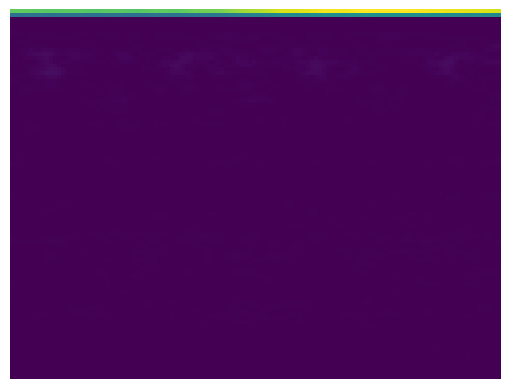

In [109]:
img = np.load(STFT_PATH)
plt.imshow(img)
plt.axis("off")
plt.savefig("../graphs/stft.png", bbox_inches="tight")
plt.show()

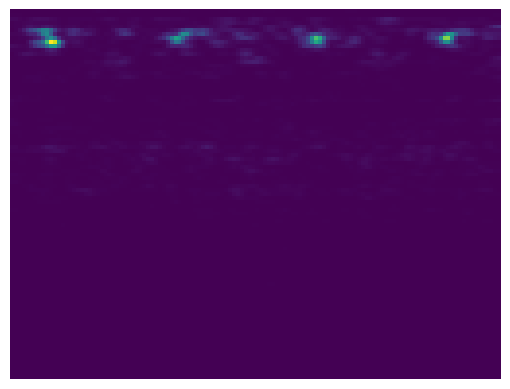

In [110]:
img = np.load(MEL_PATH)
plt.imshow(img)
plt.axis("off")
plt.savefig("../graphs/mel.png", bbox_inches="tight")
plt.show()

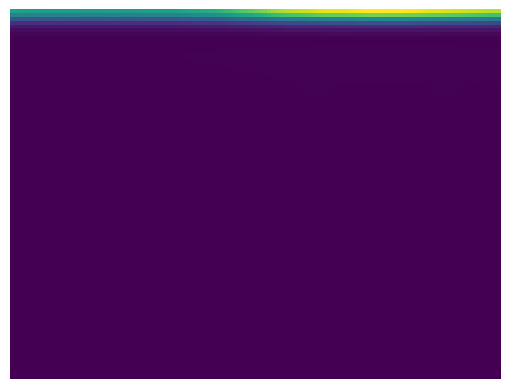

In [111]:
img = np.load(GAMMATONE_PATH)
plt.imshow(img)
plt.axis("off")
plt.savefig("../graphs/gammatone.png", bbox_inches="tight")
plt.show()

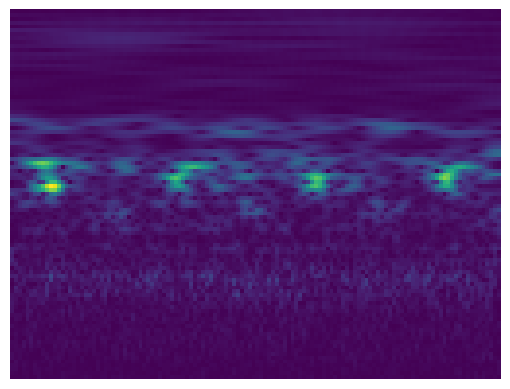

In [112]:
img = np.load(CQT_PATH)
plt.imshow(img)
plt.axis("off")
plt.savefig("../graphs/cqt.png", bbox_inches="tight")
plt.show()